In [ ]:
import torch    
import json 
from ptlpinns.models import model, transfer
from ptlpinns.perturbation import LPM, standard
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import math

from torch_failed import transfer_torch

### Load model

In [2]:
name = "undamped_k12"

undamped_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name}"
undamped_name = f"model_{name}.pth"
undamped_model, training_log = model.load_model(undamped_path, undamped_name)

12 True True True 1.0 16 [256, 256, 512]


### Problem definition

In [3]:
N = 100
t_span = (0, 5)
t_eval_np = np.linspace(t_span[0], t_span[1], N)
t_eval = torch.tensor(t_eval_np, dtype=torch.float64, requires_grad=True)

### Compute latent representations

In [4]:
H_dict = transfer_torch.compute_H_dict(undamped_model, N=N, bias=True, t_span=t_span)

H_dict_np = transfer.compute_H_dict(undamped_model, N=N, bias=True, t_span=t_span)

A dtype: torch.float64
H dtype: torch.float64


In [5]:
import numpy as np

def compare_H_dicts(H_dict_torch, H_dict_numpy, atol=1e-12, rtol=1e-8):
    for key in H_dict_numpy.keys():
        print(f"Comparing key: {key}")
        arr_np = H_dict_numpy[key]
        arr_t  = H_dict_torch[key]

        if isinstance(arr_np, torch.Tensor):
            arr_np = arr_np.detach().cpu().numpy()

        # convert torch tensor → numpy
        if isinstance(arr_t, torch.Tensor):
            arr_t = arr_t.detach().cpu().numpy()


        # norm and error
        diff   = np.linalg.norm(arr_t - arr_np)
        normnp = np.linalg.norm(arr_np)
        relerr = diff / (normnp + 1e-16)

        print(f"{key:6s}"
              f"‖diff‖={diff:.3e}  rel.err={relerr:.3e}")

        # optional: assert closeness
        if not np.allclose(arr_t, arr_np, atol=atol, rtol=rtol):
            print(f"   ⚠ values differ beyond tolerance (max abs {np.max(np.abs(arr_t - arr_np)):.2e})")

compare_H_dicts(H_dict, H_dict_np)

Comparing key: H
H     ‖diff‖=0.000e+00  rel.err=0.000e+00
Comparing key: H_ic
H_ic  ‖diff‖=0.000e+00  rel.err=0.000e+00
Comparing key: Ht
Ht    ‖diff‖=0.000e+00  rel.err=0.000e+00
Comparing key: Ht_ic
Ht_ic ‖diff‖=0.000e+00  rel.err=0.000e+00
Comparing key: N
N     ‖diff‖=0.000e+00  rel.err=0.000e+00
Comparing key: BHt
BHt   ‖diff‖=0.000e+00  rel.err=0.000e+00


### Transfer parameters

In [6]:
w_list_transfer = [1]
zeta_list = [0.0]
forcing_list = [forcing.zeroes_2D(numpy=False)]
ic_list = [torch.tensor([1, 0], dtype=torch.float64)]
epsilon_list = [0.6]
p_list = [6]
q = 3

In [7]:
M_torch = transfer_torch.compute_TL(w_0=1, zeta=0, forcing_function=forcing_list[0], ic=ic_list[0],
                                                        w_ode=training_log['w_ode'], w_ic=training_log['w_ic'], H_dict=H_dict, t=t_eval, invert=True)

A dtype: torch.float64
H dtype: torch.float64


In [35]:
H_dict["H_star"]

tensor([[-0.1483, -0.3391, -0.2121,  ..., -0.3924, -0.6356, -1.0000],
        [ 0.5504, -0.8494, -0.8591,  ...,  0.5661, -1.4011,  1.0000],
        [-0.0092, -0.3617,  0.0642,  ..., -0.4230, -0.8526, -1.0000],
        ...,
        [ 0.6445,  0.3916, -0.2546,  ...,  0.0977,  0.5392,  1.0000],
        [-0.1957, -0.3116, -0.1707,  ..., -0.4058, -0.6098, -1.0000],
        [ 0.6889,  0.2857, -0.3649,  ...,  0.0703,  0.5966,  1.0000]],
       grad_fn=<AddBackward0>)

In [25]:
H_dict_np["H_star"]

array([[-0.1483263 , -0.33906731, -0.21210366, ..., -0.3924176 ,
        -0.63560788, -1.        ],
       [ 0.55039344, -0.84936169, -0.85907487, ...,  0.56611166,
        -1.40110999,  1.        ],
       [-0.00921704, -0.3616546 ,  0.06415368, ..., -0.42301605,
        -0.85259223, -1.        ],
       ...,
       [ 0.64447856,  0.39164951, -0.2545998 , ...,  0.09769049,
         0.53920853,  1.        ],
       [-0.19570857, -0.31157319, -0.17066396, ..., -0.40582695,
        -0.60976144, -1.        ],
       [ 0.68889756,  0.28570609, -0.36487651, ...,  0.0703263 ,
         0.59657906,  1.        ]], shape=(200, 257))

In [8]:
M_numpy = transfer.compute_TL(w_0=1, zeta=0, forcing_function=forcing.zeroes_2D(numpy=True), ic=[1,0],
                                                        w_ode=training_log['w_ode'], w_ic=training_log['w_ic'], H_dict=H_dict_np, t=t_eval_np, invert=True)

In [44]:
(M_numpy) - (M_torch.cpu().detach().numpy())

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.55111512e-17,  0.00000000e+00,  2.77555756e-17],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.11022302e-16,  1.66533454e-16,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.77555756e-17, -5.55111512e-17, -1.11022302e-16],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.11022302e-16,  3.46944695e-17, -2.42861287e-17],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
      shape=(257, 257))

In [ ]:
np.linalg.pinv(M_numpy) - torch.linalg.pinv(M_torch).cpu().detach().numpy()

array([[ 4.96154639e+11,  6.03658705e+11, -2.62601490e+12, ...,
        -5.41627651e+11,  1.10829078e+12,  1.04840997e+11],
       [ 4.13145660e+10,  5.16003409e+10, -2.13570577e+11, ...,
        -4.55078997e+10,  8.89813808e+10,  6.90042953e+09],
       [ 3.33376688e+10,  3.32563845e+10, -1.85043026e+11, ...,
        -4.00624431e+10,  7.90119536e+10,  1.23921832e+10],
       ...,
       [-2.74971109e+10, -2.47832042e+10,  1.40164032e+11, ...,
         2.74231777e+10, -6.91918470e+10, -9.24314464e+09],
       [ 1.04186712e+11,  1.45522292e+11, -5.72431725e+11, ...,
        -1.11618231e+11,  2.25965320e+11,  1.82463803e+10],
       [-3.34520548e+10, -4.45944136e+10,  1.91282531e+11, ...,
         3.51309231e+10, -7.96220468e+10, -5.59874964e+09]],
      shape=(257, 257))

In [22]:
torch.linalg.pinv(M_torch).cpu().detach().numpy()

array([[ 1.32141844e+10,  5.06052279e+09,  5.22085343e+08, ...,
         2.33411354e+09, -8.16330421e+09, -2.24746064e+09],
       [ 5.06715105e+09,  7.68043173e+09, -1.70111306e+09, ...,
         2.87700945e+09, -3.96771188e+09, -8.25516242e+08],
       [ 5.42427680e+08, -1.69535992e+09,  8.37410836e+09, ...,
         1.09220098e+09, -4.66738792e+08,  3.99981004e+09],
       ...,
       [ 2.33619815e+09,  2.87374241e+09,  1.08594359e+09, ...,
         9.00252808e+09,  3.65440278e+08,  2.57804598e+08],
       [-8.15110564e+09, -3.95883156e+09, -4.44040073e+08, ...,
         3.73639590e+08,  1.71011454e+10,  6.62328540e+08],
       [-2.25362261e+09, -8.26318208e+08,  4.00321227e+09, ...,
         2.56245763e+08,  6.70034810e+08,  5.26104280e+09]],
      shape=(257, 257))

In [23]:
np.linalg.pinv(M_numpy)

array([[ 5.90636433e+11, -3.39312343e+10, -8.66713704e+11, ...,
        -1.41933752e+11,  1.86838671e+12, -2.16672765e+11],
       [ 6.33754558e+10,  3.43422370e+11, -1.08162312e+11, ...,
         3.09218221e+10,  2.14857131e+11,  2.30355373e+10],
       [-1.01985127e+11, -6.45594943e+10,  5.59746008e+11, ...,
        -1.96938288e+11, -2.41479214e+11, -1.26238785e+10],
       ...,
       [-1.05723157e+10,  4.95459682e+10, -1.49891880e+11, ...,
         3.29762080e+11,  6.95309754e+09,  2.90926627e+09],
       [ 1.34278284e+11,  6.10910659e+10, -5.39627216e+11, ...,
         6.86341052e+10,  9.51731216e+11, -8.01876800e+10],
       [-2.75386641e+10,  5.04777188e+10,  5.81904715e+10, ...,
         1.04311640e+09, -1.68122460e+11,  1.17502370e+11]],
      shape=(257, 257))

In [13]:
torch.linalg.pinv(M_torch).cpu().detach().numpy() - np.linalg.pinv(M_numpy)

array([[-5.77422249e+11,  3.89917571e+10,  8.67235790e+11, ...,
         1.44267866e+11, -1.87655002e+12,  2.14425304e+11],
       [-5.83083048e+10, -3.35741938e+11,  1.06461199e+11, ...,
        -2.80448127e+10, -2.18824843e+11, -2.38610535e+10],
       [ 1.02527555e+11,  6.28641344e+10, -5.51371899e+11, ...,
         1.98030489e+11,  2.41012475e+11,  1.66236885e+10],
       ...,
       [ 1.29085138e+10, -4.66722258e+10,  1.50977824e+11, ...,
        -3.20759552e+11, -6.58765726e+09, -2.65146168e+09],
       [-1.42429390e+11, -6.50498974e+10,  5.39183175e+11, ...,
        -6.82604656e+10, -9.34630071e+11,  8.08500085e+10],
       [ 2.52850415e+10, -5.13040370e+10, -5.41872592e+10, ...,
        -7.86870635e+08,  1.68792495e+11, -1.12241327e+11]],
      shape=(257, 257))

In [17]:
torch.linalg.cond(M_torch)

tensor(4.6102e+16, grad_fn=<SqueezeBackward1>)

In [18]:
np.linalg.cond(M_numpy)

np.float64(1.3337690265295548e+19)

In [12]:
M_torch.cpu().detach().numpy() - M_numpy

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.55111512e-17,  0.00000000e+00, -2.77555756e-17],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.11022302e-16, -1.66533454e-16,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.77555756e-17,  5.55111512e-17,  1.11022302e-16],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.11022302e-16, -3.46944695e-17,  2.42861287e-17],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
      shape=(257, 257))

In [9]:
import numpy as np

def compare_TL_dicts(H_dict_new, H_dict_new_2, keys=("H_star","H_ic","N")):
    def to_np(x):
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().numpy()
        return x
    
    for k in keys:
        a = to_np(H_dict_new[k])
        b = to_np(H_dict_new_2[k])


        diff   = np.linalg.norm(a - b)
        norm_b = np.linalg.norm(b)
        relerr = diff / (norm_b + 1e-16)
        print(f"{k:7s}‖diff‖={diff:.3e} rel.err={relerr:.3e}")

compare_TL_dicts(H_dict_new, H_dict_new_2)

NameError: name 'H_dict_new' is not defined

In [20]:
H_dict_new["M_inv"].detach().cpu().numpy()

NameError: name 'H_dict_new' is not defined

In [21]:
H_dict_new_2["M_inv"]

NameError: name 'H_dict_new_2' is not defined

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
ode = equations.ode_oscillator_1D(w_0=w_list_transfer[0], zeta=zeta_list[0], forcing_1D=lambda t: np.zeros_like(t), q=q, epsilon=epsilon_list[0])
numerical_undamped_duffing = numerical.solve_ode_equation(ode, (t_eval_np[0], t_eval_np[-1]), t_eval_np, ic_list[0])

## Standard Perturbation

In [ ]:
NN_TL_solution_standard, perturbation_solution_standard, _ = transfer_torch.compute_perturbation_solution(w_list_transfer, zeta_list, epsilon_list, p_list, ic_list, forcing_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, solver="standard", power=q)
NN_TL_solution_standard = NN_TL_solution_standard.squeeze()

A dtype: torch.float64
H dtype: torch.float64
forcing_value dtype: torch.float64
H_star dtype: torch.float64
Rf dtype: torch.float64
Ric dtype: torch.float64
R dtype: torch.float64
Minv dtype: torch.float64


In [ ]:
PINN_x_solution_standard = [perturbation_solution_standard[i][:, 0] for i in range(len(perturbation_solution_standard))]
PINN_x_solution_series_standard = standard.calculate_general_series(PINN_x_solution_standard, epsilon=epsilon_list[0])

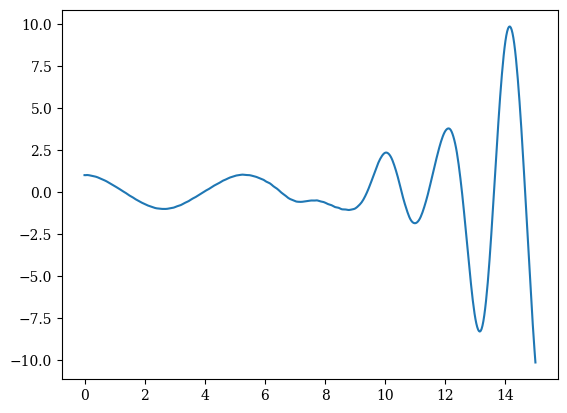

In [ ]:
import matplotlib.pyplot as plt

plt.plot(t_eval_np, perturbation_solution_standard[0][:, 0].detach(), label="PINN (standard)")

In [ ]:
stop

NameError: name 'stop' is not defined

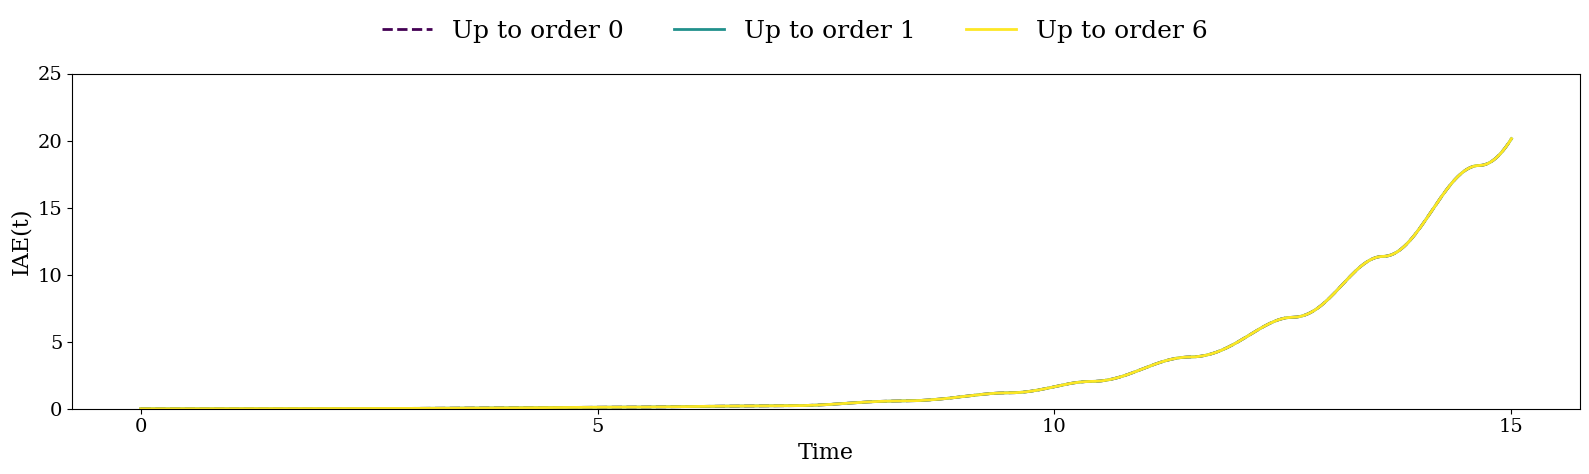

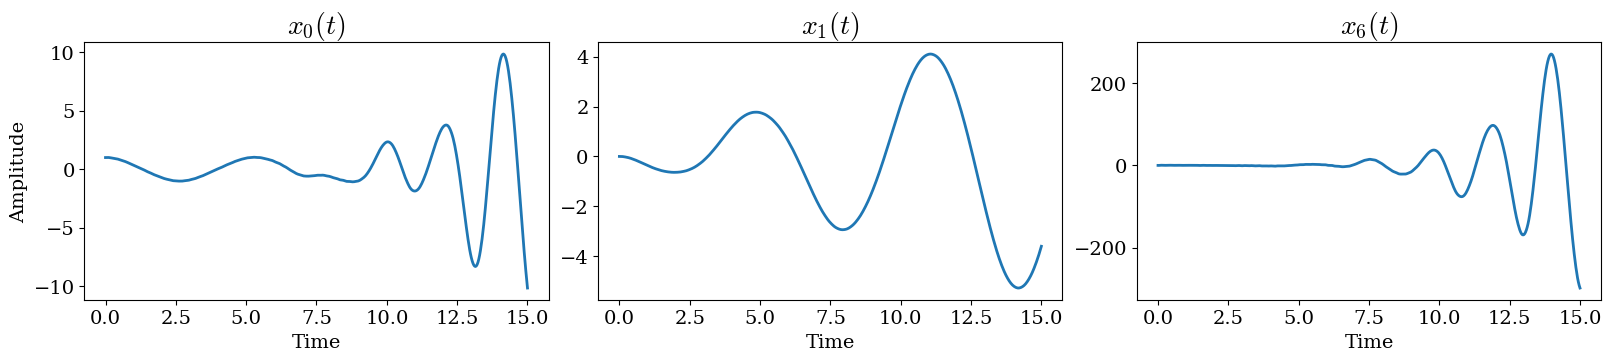

In [ ]:
standard.plot_IAE_and_subplots(PINN_x_solution_series_standard, numerical_undamped_duffing, perturbation_solution_standard, t_eval_np, selected_orders=[0, 1, 6])

In [ ]:
stop

NameError: name 'stop' is not defined

## Lindstedt-Poincare method

In [ ]:
w_sol = []
NN_TL_solution_LPM, perturbation_solution_LPM, _ = transfer_torch.compute_perturbation_solution(w_list_transfer, zeta_list, epsilon_list, p_list, ic_list, forcing_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, solver="LPM", w_sol = w_sol)
NN_TL_solution_LPM = NN_TL_solution_LPM.squeeze()

A dtype: torch.float32
H dtype: torch.float32
forcing_value dtype: torch.float32
H_star dtype: torch.float32
Rf dtype: torch.float32
Ric dtype: torch.float32
R dtype: torch.float32
Minv dtype: torch.float32


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [ ]:
w_final_list = []

for index in range(len(epsilon_list)):
    w_final_list.append(LPM.calculate_w_series(w_sol[0], epsilon_list[index], rwtol=1e-12))

w_final_list

[[1,
  np.float64(1.2249615417317095),
  np.float64(1.1954441094887285),
  np.float64(1.2039789574238693),
  np.float64(1.2007460172636413),
  np.float64(1.2021424509126646),
  np.float64(1.2014932278440398)]]

In [ ]:
_, w_teor = LPM.estimate_period_frequency(w_0=w_list_transfer[0], zeta=zeta_list[0], ic=ic_list[0], q=q, epsilon=epsilon_list[0])
w_teor

np.float64(1.2018028846153845)

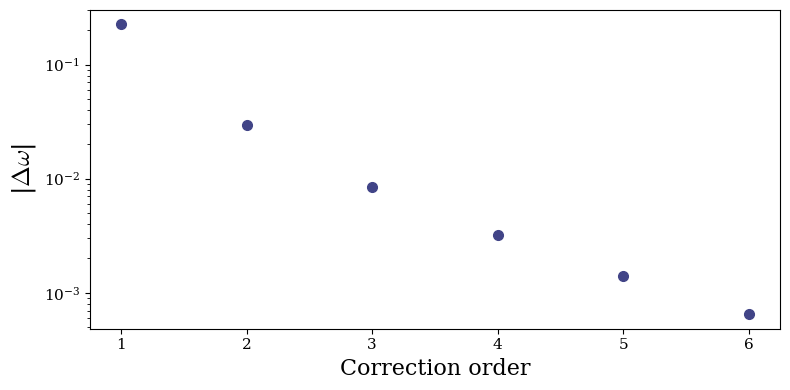

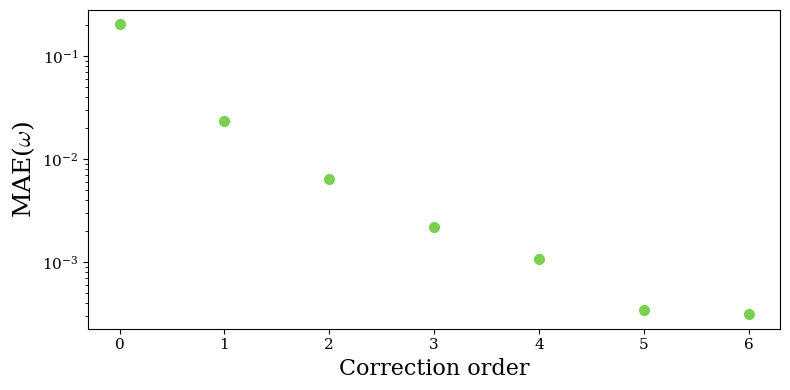

In [ ]:
LPM.relative_error(w_final_list[0])
LPM.w_absolute_error(w_final_list[0], w_teor)

In [ ]:
w_final = w_final_list[0][-1]
t_eval_lpm, t_eval_standard = LPM.t_eval_lpm(t_eval, w_final)
compare_len = t_eval_standard.shape[0]

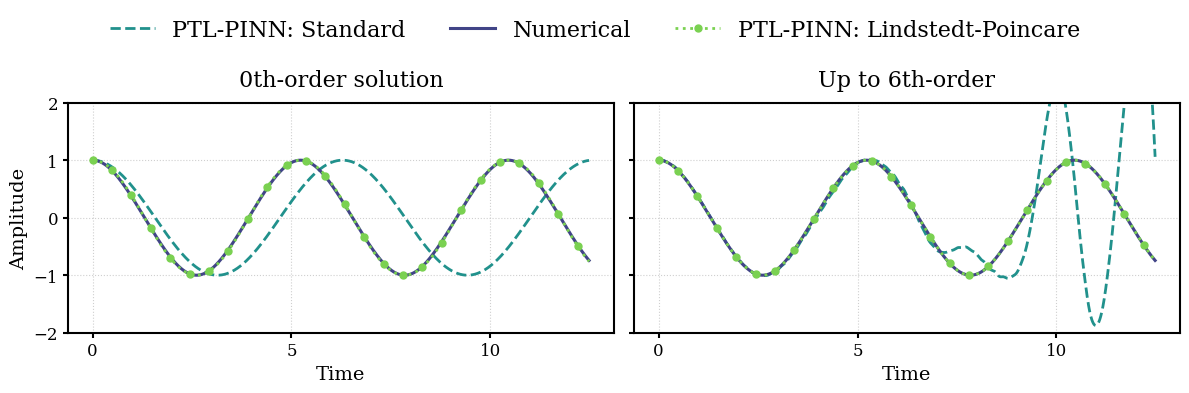

In [ ]:
standard.plot_comparison_standard_vs_lpm(t_eval_standard, t_eval_lpm, [i[:compare_len] for i in perturbation_solution_standard], NN_TL_solution_standard[:compare_len], perturbation_solution_LPM, NN_TL_solution_LPM, numerical_undamped_duffing[:, :compare_len], order=p_list[0])

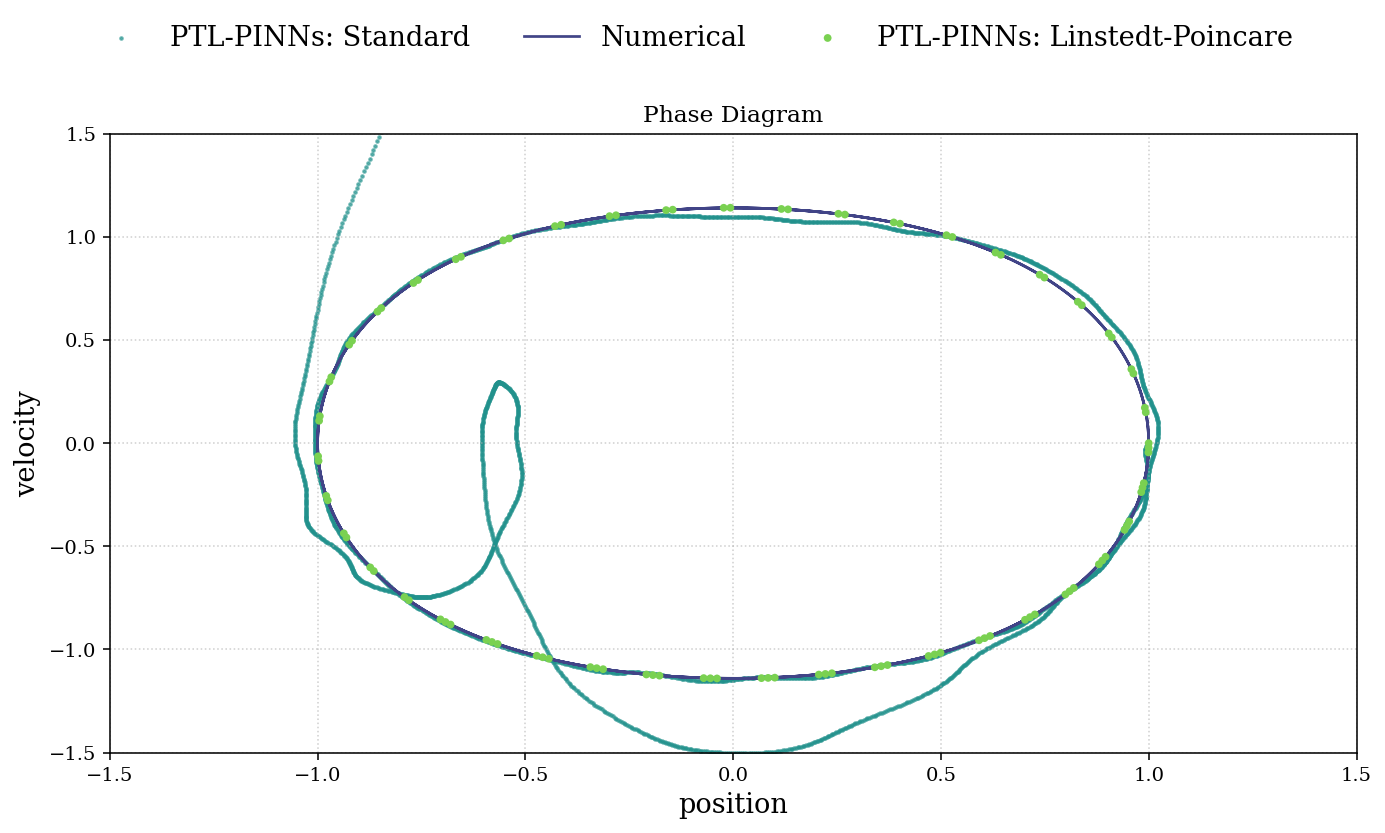

In [ ]:
LPM.plot_multiple_phase_diagrams(
    [NN_TL_solution_LPM, numerical_undamped_duffing, NN_TL_solution_standard],
    labels=["PTL-PINNs: Linstedt-Poincare", "Numerical", "PTL-PINNs: Standard"],
    lpm_index=0,
    omega=w_teor,
    lpm_stride=50,
    xlim=(-1.5, 1.5),
    ylim=(-1.5, 1.5))